In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importing files and creating arrays
data = pd.read_csv("input_data/trial_2/raw_gyro_data.csv")
print(data.info())
print("\n")
print(data.head())

t = data["sampleNum"]
l = data["label"]
normal_indices = np.array(np.where(l == "Normal")).flatten()
reckless_indices = np.array(np.where(l == "Reckless")).flatten()

g_x_all = data["gyro_x"]
g_y_all = data["gyro_y"]
g_z_all = data["gyro_z"]

g_x_normal = np.array(g_z_all[normal_indices])
g_x_reckless = np.array(g_z_all[reckless_indices])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529800 entries, 0 to 529799
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   gyro_z     529800 non-null  float64
 1   gyro_x     529800 non-null  float64
 2   gyro_y     529800 non-null  float64
 3   label      529800 non-null  object 
 4   sampleNum  529800 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 20.2+ MB
None


     gyro_z    gyro_x    gyro_y   label  sampleNum
0  0.078723  1.382979 -0.037234  Normal          0
1  0.203191 -0.215957 -0.218085  Normal          0
2  0.060638  0.838298 -0.050000  Normal          0
3 -0.042553  0.610638 -0.374468  Normal          0
4  0.001064  0.442553 -0.219149  Normal          0


# Plotting
The following plots can illustrate the differences between normal and reckless driving. Note that the plots are based on all 948 data points, making the differences very clear.

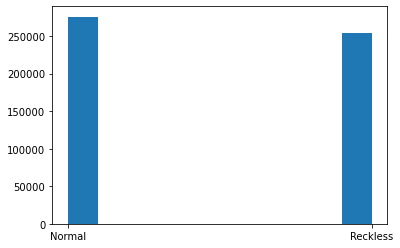

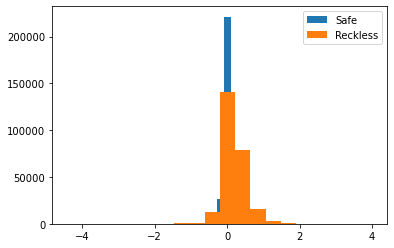

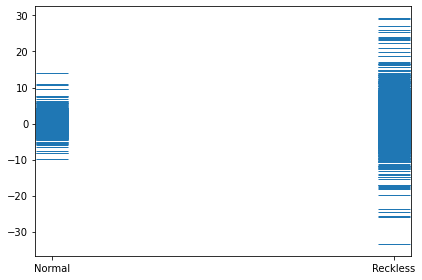

In [3]:
plt.hist(l)
plt.show()

fig, ax = plt.subplots()
ax.hist(g_x_normal, bins=20, label="Safe")
ax.hist(g_x_reckless, bins=20, label="Reckless")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.scatter(l, g_x_all, s=1000, marker="_", linewidth=1)
fig.tight_layout()
plt.show()


# Finding various statistical quantities:
The data can be studied through some statistical quantities.
Mean, standard deviation and range are expressed above. In addition, we can define energy, entropy and various other quantities which can be used to classify behaviour without using rtificial intelligence.

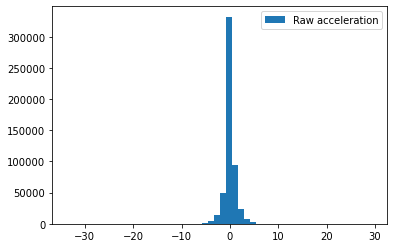

In [4]:
# Using raw data here is probably most sensible.
# The data used above already contains some statistical ariables.
raw_data = pd.read_csv("input_data/trial_2/raw_gyro_data.csv")
g_x_raw = np.array(raw_data["gyro_x"])
g_y_raw = np.array(raw_data["gyro_z"])
g_z_raw = np.array(raw_data["gyro_y"])

fig, ax = plt.subplots()
ax.hist(g_x_raw, bins=50, label="Raw acceleration")
#ax.hist(a_x_normal, label="Safe")
ax.legend()
plt.show()

We can define a number of statistical quantities in order to characterize the behaviour of the rider. Following are some, but others, such as maximun acceleration value, average acceleration value and intensity $\frac{1}{T} \Sigma_t \sqrt{a_x^2 + a_y^2 + a_z^2}$ can be implemented.

In [5]:
# Defining some statistical quantities that can be useful
# If more are needed, they should be defined with a similar
# syntax for simple inclusion in the functions below.
def movement_variation(N, ax, ay, az):
    """Returns variation in acceleration."""
    # I don't know if this is useful, nor if we can expect  it to be.
    # In the sheep paper, it is very unclear if the
    # vectors ax, ay and az are actually supposed to be
    # acceleration vectors.
    dx = np.sum(np.abs(ax[:-1] - ax[1:]))
    dy = np.sum(np.abs(ay[:-1] - ay[1:])) 
    dz = np.sum(np.abs(az[:-1] - az[1:]))
    return (dx + dy + dz)/N

def sma(N, ax, ay, az):
    '''Returns signal magnitude area (SMA) of acceleration'''
    x = np.sum(np.abs(ax))
    y = np.sum(np.abs(ay))
    z = np.sum(np.abs(az))
    return (x + y + z)/N

def entropy(N, ax, ay, az):
    T = np.abs(np.array(ax + ay + az))
    S = np.sum((1+T) * np.log(1+T))
    return S/N

def energy(N, ax, ay, az):
    v = np.array(ax**2 + ay**2 + az**2)
    e = np.sum(v)
    return e/N

In [6]:
# Importing raw data, and separating according to label
raw_t = raw_data["sampleNum"]
raw_l = raw_data["label"]
raw_normal_indices = np.array(np.where(raw_l == "Normal")).flatten()
raw_reckless_indices = np.array(np.where(raw_l == "Reckless")).flatten()

#g_x_all = data["mean_acc_x"]
#g_y_all = data["mean_acc_y"]
#g_z_all = data["mean_acc_z"]

g_x_normal = np.array(g_x_raw[raw_normal_indices])
g_y_normal = np.array(g_y_raw[raw_normal_indices])
g_z_normal = np.array(g_z_raw[raw_normal_indices])
g_x_reckless = np.array(g_x_raw[raw_reckless_indices])
g_y_reckless = np.array(g_y_raw[raw_reckless_indices])
g_z_reckless = np.array(g_z_raw[raw_reckless_indices])

# Number of data points in a segment.
# L = 200 corresponds to one second of data.
L = 400

In [13]:
# Plots the quantities defined above as a function of time
def get_quantity(quantity, ax, ay, az, L):
    N = len(ax)//L
    values = np.zeros(N)
    for i in range(N):
        values[i] = quantity(N, ax[L*i:L*(i+1)], ay[L*i:L*(i+1)], az[L*i:L*(i+1)])
    return values
    
def plot_differences(quantity, ax_n, ay_n, az_n, ax_r, ay_r, az_r, L, save=False):
    N = len(ax_n)//L
    M = len(ax_r)//L
    val_n = get_quantity(quantity, ax_n, ay_n, az_n, L)
    val_r = get_quantity(quantity, ax_r, ay_r, az_r, L)

    plt.plot(np.linspace(0, N, len(val_n)), val_n, 'o', markersize=1.2, label="Rolig")
    #plt.plot(np.linspace(0, M, len(val_r)), val_r, label="reckless")
    plt.plot(np.linspace(0, M, len(val_r)), np.full(len(val_r), np.mean(val_n)), linestyle="--", color="k", label="Snitt(Rolig)")
    plt.plot(np.linspace(0, M, len(val_r)), np.mean(val_n) - val_r, 'o', markersize=1.2, label="Snitt(Rolig) – Vågal")
    plt.plot(np.linspace(0, M, len(val_r)), np.zeros(len(val_r)), linestyle="-", color="k")
    plt.legend()
    if save:
        plt.title("Forsøk 2, SMA med gyroskop")
        plt.xlabel("Tid")
        plt.ylabel("SMA")
        plt.savefig("klassisk_SMA_gyro_2.pdf", format='pdf')
    plt.show()
    print("Mean of normal data:", np.mean(val_n))
    print("Mean of reckless data:", np.mean(val_r))
    print("")

Signal moment magnitude:


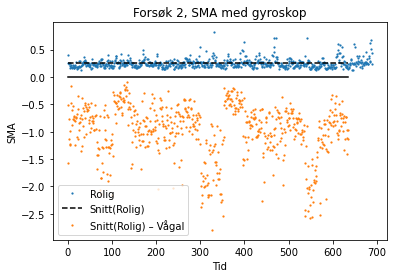

Mean of normal data: 0.25207391019863085
Mean of reckless data: 1.2396027295884378

Movement variation:


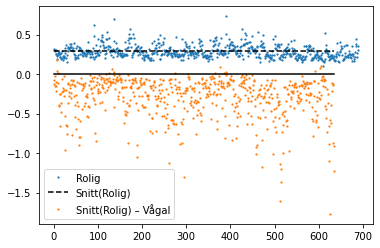

Mean of normal data: 0.2881096453204518
Mean of reckless data: 0.5834173914305275

Entropy:


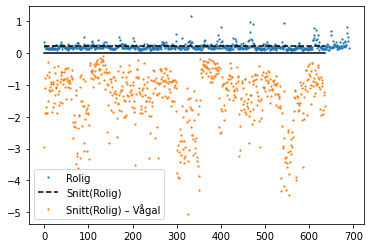

Mean of normal data: 0.21406267008779667
Mean of reckless data: 1.6004439603939045

Energy:


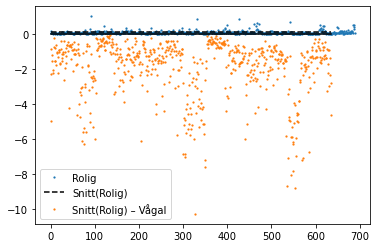

Mean of normal data: 0.09659919329100221
Mean of reckless data: 2.042765191682126



In [14]:
print("Signal moment magnitude:")
plot_differences(sma, g_x_normal, g_y_normal, g_z_normal, g_x_reckless, g_y_reckless, g_z_reckless, L, save=True)

print("Movement variation:")
plot_differences(movement_variation, g_x_normal, g_y_normal, g_z_normal, g_x_reckless, g_y_reckless, g_z_reckless, L)
print("Entropy:")
plot_differences(entropy, g_x_normal, g_y_normal, g_z_normal, g_x_reckless, g_y_reckless, g_z_reckless, L)
print("Energy:")
plot_differences(energy, g_x_normal, g_y_normal, g_z_normal, g_x_reckless, g_y_reckless, g_z_reckless, L)

From the figures above, it is visible that reckless rides can be separated from normal rides by comparing the deviation of one (or preferably more) of these quantities with the average value of a preprocessed collection of safe rides. The more indicators are above average, the more likely it is that the driver is behaving unsafely.
Including a preprocessed collection of reckless rides in order to make an interval in which it is likely that the driver behaves safely might improve this.

In [25]:
def normal_or_reckless_gyro(ax, ay, az, gx, gy, gz, L, means):
    N = len(ax)//L
    M = len(gx)//L
    vals_a = get_quantities(ax, ay, az, L)
    vals_g = get_quantities(gx, gy, gz, L)
    vals = np.concatenate(vals_a, vals_g)
    recklessness = np.full((N,len(means)), False)
    print(means.shape)
    for i in range(N):
        # reckless - normal > 0:
        recklessness[i,:len(vals_a)] = vals_a[:,i] > means[:len(vals_a)]
        if i % 2 == 0:
            reclessness[i,len(vals_a)+1:] = vals_g[:,i] > means[len(vals_a)+1:]
            
    return voting(recklessness) 

def voting_gyro(A):
    B = A.astype(int)
    B = np.sum(B, axis=1)
    return np.where(B >= 3, True, False)
    
def get_quantities(ax, ay, az, L):
    SMA = get_quantity(sma, ax, ay, az, L)
    MV = get_quantity(movement_variation, ax, ay, az, L)
    S = get_quantity(entropy, ax, ay, az, L)
    E = get_quantity(energy, ax, ay, az, L)
    return np.array([SMA, MV, S, E])[:-1] # Exclude quantities by slicing here.

def get_means(ax, ay, az, L):
    N = len(ax)//L
    vals = get_quantities(ax, ay, az, L)
    means = np.array(np.mean(vals, axis=1))
    return means

# Using this method, the following arrays contain which segments 
# are deemed reckless from the normal and reckless data arrays.
# This means that the array "reckless_segments" should all be true,
# and the array "false_positives" should all be false, ideally.
# Without majority voting, I would expect to get about 50 % true 
# in the false positives array -- corresponding to pure guesswork.
# With majority voting however, the result will hopefully improve.
means_gn = get_means(g_x_normal, g_y_normal, g_z_normal, L)
reckless_segments = normal_or_reckless(g_x_reckless, g_y_reckless, g_z_reckless, L, means_n)
false_positives = normal_or_reckless(g_x_normal, g_y_normal, g_y_normal, L, means_n)

tp = np.sum(reckless_segments)/len(reckless_segments)
fp = np.sum(false_positives)/len(false_positives)
tn = 1-fp
fn = 1-tp

print("Percantage of true positives:\t", 
      round(tn, 4)*100, "%")
print("Percentage of false positives:\t",
      round(fp, 4)*100, "%")

accuracy = (tp + tn) / (tp + tn + fp +fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 / ((1/precision) + (1/recall))
fpr = fp / (fp + tn)

#acc = (true_pos*len(reckless_segments) + true_neg*len(false_positives))/(len(reckless_segments) + len(false_positives))
print("accuracy:\t", 
        round(accuracy, 4)*100, "%")
print("Precision:\t", 
        round(precision, 4)*100, "%")
print("Recall:\t\t", 
        round(recall, 4)*100, "%")
print("F1-score:\t", 
        round(f1_score, 4)*100, "%")




Percantage of true positives:	 90.42 %
Percentage of false positives:	 9.58 %
accuracy:	 94.11 %
Precision:	 91.08000000000001 %
Recall:		 97.8 %
F1-score:	 94.32000000000001 %


# Second experiment